In [1]:
"""
author: Yang
time: 2021.1.27
"""

from random import shuffle

from numpy import dtype
import tensorflow as tf
from utils import *
from sklearn.model_selection import KFold
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())


In [2]:

def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")

dic={'A':'A','T':'T','G':'G','C':'C'}
dic_con={'A':1,'T':2,'G':3,'C':4}


def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")
non_test=readTxt("datasets/non_test.txt")
non_train=readTxt("datasets/non_train.txt")

strong_test=readTxt("datasets/strong_test.txt")
strong_train=readTxt("datasets/strong_train.txt")
weak_test=readTxt("datasets/weak_test.txt")
weak_train=readTxt("datasets/weak_train.txt")

def GenerateFromTextToNumpy(label,train):
    train_con=[]
    train_text=[]
    train_y=[]
    train_text_5=[]
    for i in train:
        t=threeSequecne(i,4) # 化为三元组 步长为1
        train_text.append(np.array(t))

        t=threeSequecne(i,7) # 化为三元组 步长为1
        train_text_5.append(np.array(t))

        con_t=[dic_con[key] for key in i]
        train_con.append(np.array(con_t))
        
        train_y.append(np.array([label]))
    train_con=np.array(train_con)
    train_text=np.array(train_text)
    train_y=np.array(train_y)
    train_text_5=np.array(train_text_5)
    return (train_con,train_text,train_y,train_text_5)


non_train_data=GenerateFromTextToNumpy(0,non_train)
strong_train_data=GenerateFromTextToNumpy(1,strong_train)
weak_train_data=GenerateFromTextToNumpy(0,weak_train)
feature_text=np.concatenate((strong_train_data[1],weak_train_data[1]))
train_con=np.concatenate((strong_train_data[0],weak_train_data[0]))[:,:,np.newaxis]


train_text=feature_text
train_text_5=np.concatenate((strong_train_data[3],weak_train_data[3]))
train_y=np.concatenate((strong_train_data[2],weak_train_data[2]))



def GenerateLayerTwoTestData():
    strong_test_data=GenerateFromTextToNumpy(1,strong_test)
    weak_test_data=GenerateFromTextToNumpy(0,weak_test)
    test_x={"con":np.concatenate((strong_test_data[0],weak_test_data[0]))[:,:,np.newaxis],"text":np.concatenate((strong_test_data[1],weak_test_data[1])),"text_5":np.concatenate((strong_test_data[3],weak_test_data[3]))}
    test_y=np.concatenate((strong_test_data[2],weak_test_data[2]))
    return test_x,test_y

test_x,test_y=GenerateLayerTwoTestData()


In [3]:
def self_evaluate(x,y):
    res=tf.nn.sigmoid(model.predict(x))  
    res=np.array(res)
    res[res>=0.5]=1
    res[res<0.5]=0
    sum=0
    correct=0
    for i,j in zip(res,y):
        sum+=1
        if i==j:
            correct+=1
    return correct/sum

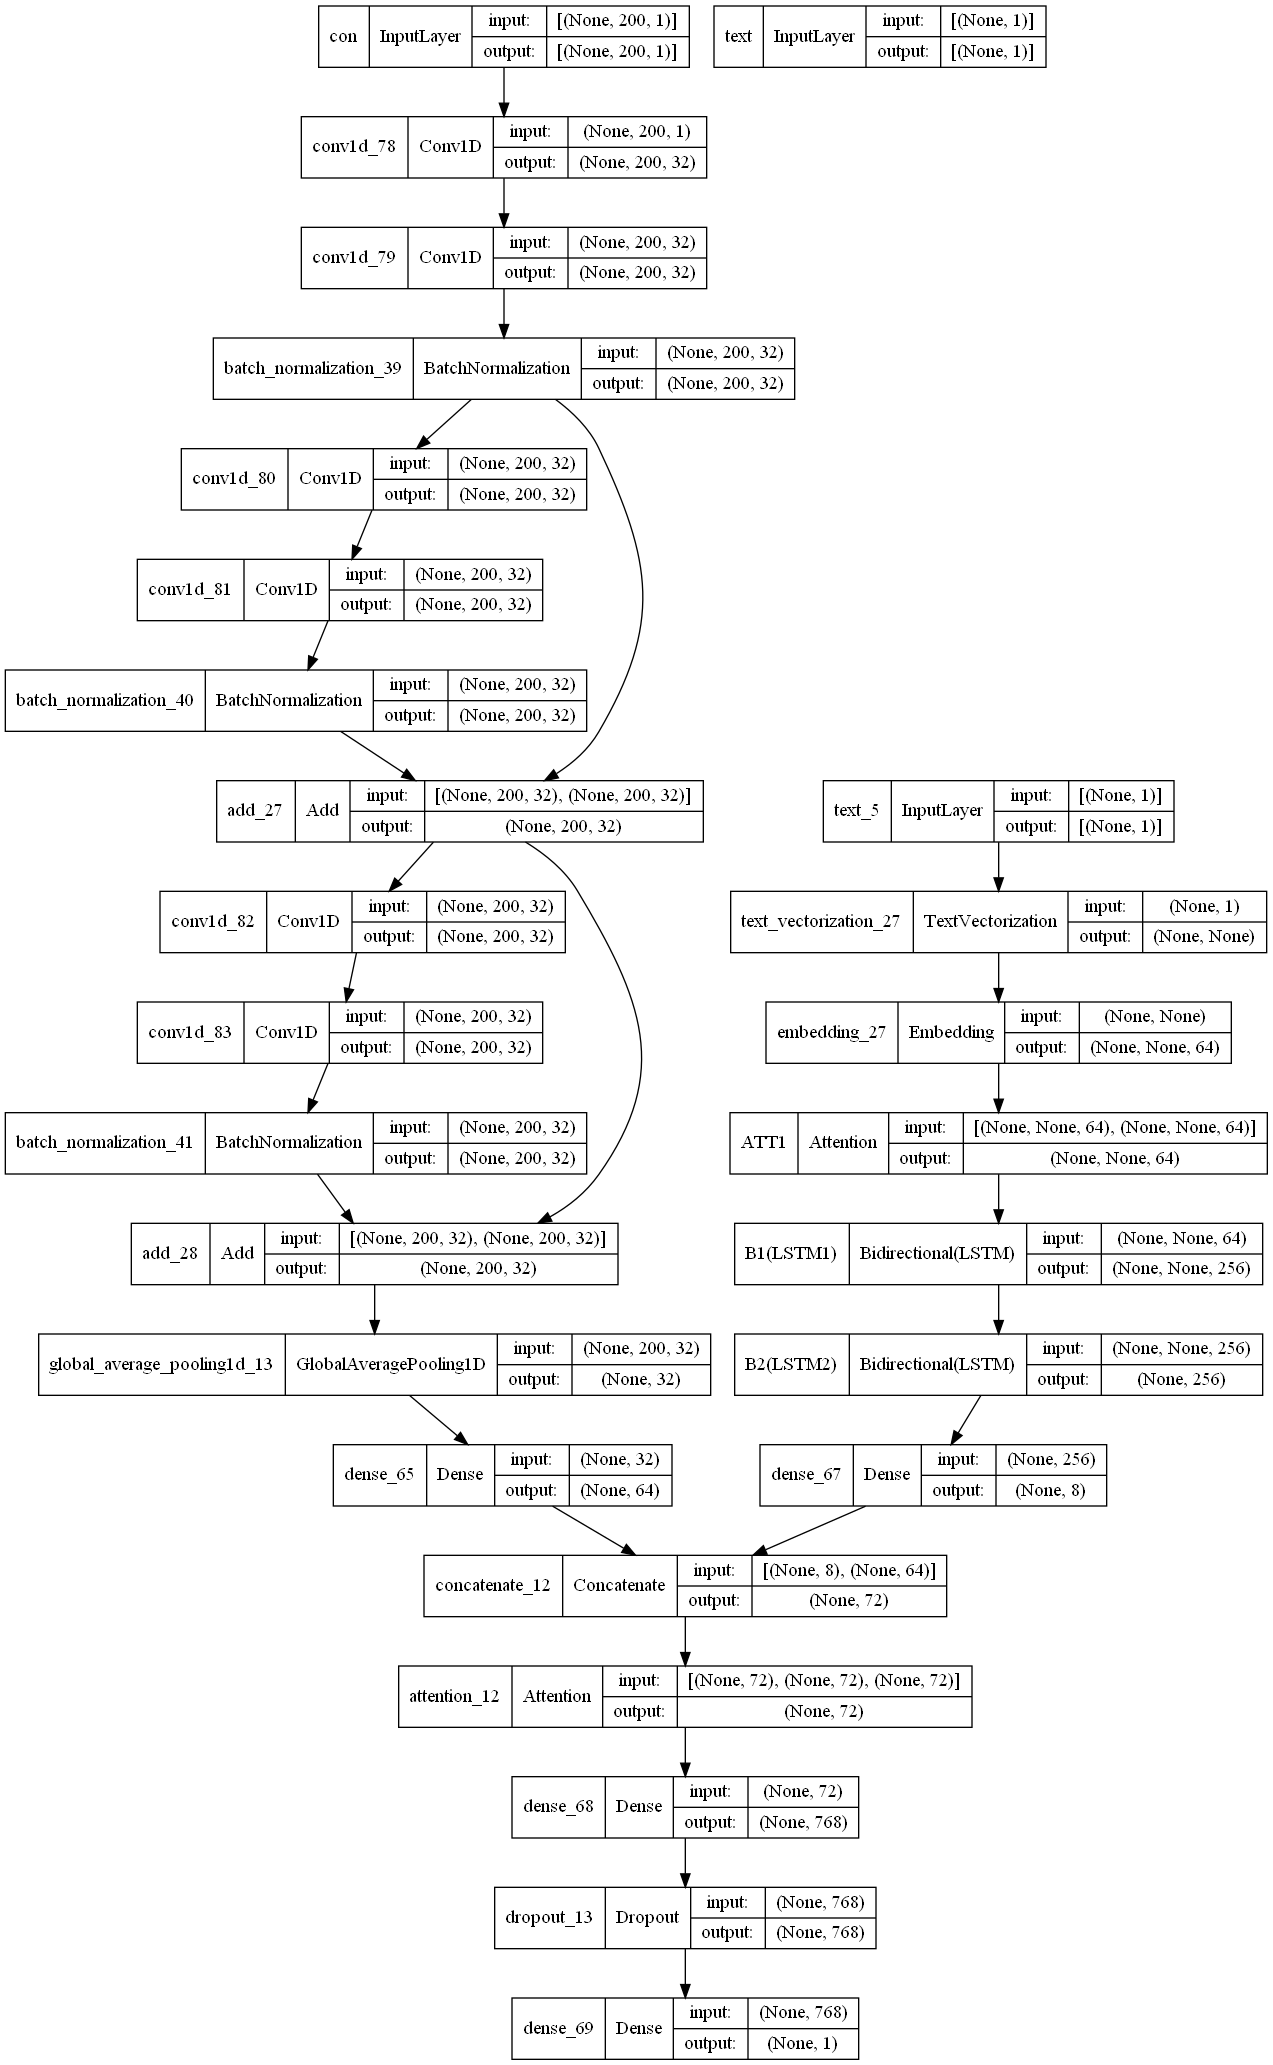

In [12]:
def load_model():
        global encoder
        kernel_num=32
        input_con=tf.keras.Input(shape=(200,1),name='con')
        y=tf.keras.layers.Conv1D(kernel_num,kernel_size=3,strides=1,padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_con)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=3,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        
        block1_output=tf.keras.layers.BatchNormalization()(y)

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=3,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block1_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=3,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.BatchNormalization()(y)
        
        block2_output=tf.keras.layers.add([y,block1_output])

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block2_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.BatchNormalization()(y)
        
        block3_output=tf.keras.layers.add([y,block2_output])
        



        y=tf.keras.layers.GlobalAveragePooling1D()(block3_output)
        y=tf.keras.layers.Dense(64,activation='relu')(y)
 
        input_text=tf.keras.Input(shape=(1,),dtype='string',name="text")
        encoder=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder.adapt(train_text)
        x=encoder(input_text)

        x=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(x)
        x=tf.keras.layers.Attention(name="ATT12")([x,x])
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,name="LSTM12"),name="B11")(x)
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,name="LSTM21"),name="B12")(x)
        x=tf.keras.layers.Dense(8,activation='relu')(x)

        input_text_5=tf.keras.Input(shape=(1,),dtype='string',name="text_5")
        encoder_5=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder_5.adapt(train_text_5)
        z=encoder_5(input_text_5)

        z=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(z)
        z=tf.keras.layers.Attention(name="ATT1")([z,z])
        z=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,name="LSTM1"),name="B1")(z)
        z=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,name="LSTM2"),name="B2")(z)
        z=tf.keras.layers.Dense(8,activation='relu')(z)

        #x=tf.keras.layers.add([z,x])

        feature_layer=tf.keras.layers.concatenate([z,y])
        att=tf.keras.layers.Attention()([feature_layer,feature_layer,feature_layer])

        d=tf.keras.layers.Dense(768,activation='relu')(att)
        d=tf.keras.layers.Dropout(0.001)(d)
        output=tf.keras.layers.Dense(1)(d)
        model=tf.keras.Model([input_text,input_con,input_text_5],output)
        base_learning_rate = 0.001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
        return model
model=load_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [5]:
kf=KFold(n_splits=10,shuffle=True,random_state=5)
t=kf.split(train_text)
index_list=[(i[0],i[1]) for i in t]

In [8]:
def train(index):    
    epochs=130
    acc=0
    loss=100
    text={}
    t_acc=0
    for i in range(epochs):
        if i<50:
            lr=0.001
        elif i<100:
            lr=0.0005
        else:
            lr=0.0001
            
        def scheduler(epoch):
            # 前5个epoch学习率保持不变，5个epoch后学习率按比例衰减
            return lr
        reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

        print(f"index:{index},epochs:{i}")
        history=model.fit(each_fold_train_x,each_fold_train_y,validation_data=(each_fold_val_x,each_fold_val_y),shuffle=True,epochs=1,batch_size=128,callbacks=[reduce_lr])
        t=returnAccuracy2()

        if i>=0:
            if (history.history["val_accuracy"][0]>=acc and history.history["val_loss"][0]<=loss) or history.history["accuracy"][0]>=t_acc:
                acc=history.history["val_accuracy"][0]
                loss=history.history["val_loss"][0]
                t_acc=history.history["accuracy"][0]
                text=t
            
        print(text)
    record.append(text) 



In [9]:
po_test=test_x.copy()
po_test["con"]=po_test["con"][0:100]
po_test["text"]=po_test["text"][0:100]
po_test["text_5"]=po_test["text"][0:100]
ne_test=test_x.copy()
ne_test["con"]=ne_test["con"][100:200]
ne_test["text"]=ne_test["text"][100:200]
ne_test["text_5"]=ne_test["text_5"][100:200]
def evaluate(x,y):
    res=model.predict(x)
    t=np.array(tf.nn.sigmoid(res),dtype="float32")
    co=0
    num=y.shape[0]
    for i in range(num):
        if int(t[i][0]+0.5)==y[i]:
            co+=1
    return co/num
def returnAccuracy2():
    import math
    TP=self_evaluate(po_test,test_y[0:100])
    TN=self_evaluate(ne_test,test_y[100:])
    FP=1-TN
    FN=1-TP
    SN=TP/(TP+FN)
    SP=TN/(TN+FP)
    ACC=(TP+TN)/(TP+TN+FN+FP)
    try:
        MCC=(TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    except:
        MCC=-1
    text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
    return text

In [10]:
name="layer2_ResCNN"

In [ ]:
train_acc=[]
val_acc=[]
test_acc=[]
record=[]
for i in range(10):
    fold_order=i
    (train_index,val_index)=index_list[fold_order]
    each_fold_train_x={"con":train_con[train_index],"text":train_text[train_index],"text_5":train_text_5[train_index]}
    each_fold_train_y=train_y[train_index]
    each_fold_val_x={"con":train_con[val_index],"text":train_text[val_index],"text_5":train_text_5[val_index]}
    each_fold_val_y=train_y[val_index]
    model=load_model()
    model.load_weights(f"checkpoint\{name}_{i}")
    train_acc.append(self_evaluate(each_fold_train_x,each_fold_train_y))
    val_acc.append(self_evaluate(each_fold_val_x,each_fold_val_y))
    text=returnAccuracy2()
    record.append(text)
    test_acc.append(text['ACC'])
    print("------")


In [ ]:
print("train_acc | evaluate_acc | test_acc")
for index in range(10):
    print(f"{int(train_acc[index]*10000)/100}           {int(val_acc[index]*10000)/100}      {int(test_acc[index]*10000)/100}")
print("----")
print(f"{int(np.mean(train_acc)*10000)/100}           {int(np.mean(val_acc)*10000)/100}      {int(np.mean(test_acc)*10000)/100}")

In [13]:
name="layer2_Fuse"
record=[]
for i in range(0,10):
    fold_order=i
    (train_index,val_index)=index_list[fold_order]
    each_fold_train_x={"con":train_con[train_index],"text":train_text[train_index],"text_5":train_text_5[train_index]}
    each_fold_train_y=train_y[train_index]
    each_fold_val_x={"con":train_con[val_index],"text":train_text[val_index],"text_5":train_text_5[val_index]}
    each_fold_val_y=train_y[val_index]
    model=load_model()
    train(i)
    #model.save_weights(f"checkpoint\{name}_{i}")
print(name)


ACC=0
SP=0
SN=0
MCC=0
for i in record:
    ACC+=i["ACC"]
    SP+=i["SP"]
    SN+=i["SN"]
    MCC+=i["MCC"]
ACC/=10
SP/=10
SN/=10
MCC/=10
text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
print(text)

index:0,epochs:0
11/11 [==============================] - 15s 458ms/step - loss: 2.1876 - accuracy: 0.4981 - val_loss: 2.0977 - val_accuracy: 0.5101 - lr: 0.0010
{'ACC': 0.5, 'SP': 0.0, 'SN': 1.0, 'MCC': -1}
index:0,epochs:1
11/11 [==============================] - 1s 123ms/step - loss: 1.9514 - accuracy: 0.5266 - val_loss: 1.8831 - val_accuracy: 0.5101 - lr: 0.0010
{'ACC': 0.5, 'SP': 0.0, 'SN': 1.0, 'MCC': -1}
index:0,epochs:2
11/11 [==============================] - 1s 122ms/step - loss: 1.7699 - accuracy: 0.5026 - val_loss: 1.7151 - val_accuracy: 0.5101 - lr: 0.0010
{'ACC': 0.5, 'SP': 0.0, 'SN': 1.0, 'MCC': -1}
index:0,epochs:3
11/11 [==============================] - 1s 123ms/step - loss: 1.5985 - accuracy: 0.5131 - val_loss: 1.5652 - val_accuracy: 0.5101 - lr: 0.0010
{'ACC': 0.5, 'SP': 0.0, 'SN': 1.0, 'MCC': -1}
index:0,epochs:4
11/11 [==============================] - 1s 122ms/step - loss: 1.4689 - accuracy: 0.5064 - val_loss: 1.4409 - val_accuracy: 0.5101 - lr: 0.0010
{'ACC': 0.

In [69]:
for i in record:
    print(i)

{'ACC': 0.815, 'SP': 0.66, 'SN': 0.97, 'MCC': 0.6626441316955085}


In [66]:
import copy

In [67]:
rrecord=copy.deepcopy(record)

In [72]:
rrecord

[{'ACC': 0.875, 'SP': 0.75, 'SN': 1.0, 'MCC': 0.7745966692414834},
 {'ACC': 0.815, 'SP': 0.65, 'SN': 0.98, 'MCC': 0.6673863619872193},
 {'ACC': 0.835, 'SP': 0.67, 'SN': 1.0, 'MCC': 0.7097600992562492},
 {'ACC': 0.87, 'SP': 0.76, 'SN': 0.98, 'MCC': 0.7585854404968749},
 {'ACC': 0.865, 'SP': 0.76, 'SN': 0.97, 'MCC': 0.7466492433418158},
 {'ACC': 0.845, 'SP': 0.7, 'SN': 0.99, 'MCC': 0.7209830607315093},
 {'ACC': 0.84, 'SP': 0.69, 'SN': 0.99, 'MCC': 0.7128336889709044},
 {'ACC': 0.77, 'SP': 0.54, 'SN': 1.0, 'MCC': 0.6081636405595373},
 {'ACC': 0.905, 'SP': 0.81, 'SN': 1.0, 'MCC': 0.8250286473253903},
 {'ACC': 0.815, 'SP': 0.66, 'SN': 0.97, 'MCC': 0.6626441316955085}]

In [73]:
ACC=0
SP=0
SN=0
MCC=0
for i in rrecord:
    ACC+=i["ACC"]
    SP+=i["SP"]
    SN+=i["SN"]
    MCC+=i["MCC"]
ACC/=10
SP/=10
SN/=10
MCC/=10
text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
print(text)

{'ACC': 0.8435, 'SP': 0.6990000000000001, 'SN': 0.9880000000000001, 'MCC': 0.7186630983606491}


In [46]:
ACC=0
SP=0
SN=0
MCC=0
for i in record:
    ACC+=i["ACC"]
    SP+=i["SP"]
    SN+=i["SN"]
    MCC+=i["MCC"]
ACC/=10
SP/=10
SN/=10
MCC/=10
text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
print(text)

{'ACC': 0.7315, 'SP': 0.5970000000000001, 'SN': 0.866, 'MCC': 0.5047233226768686}


In [ ]:
# loacl {'ACC': 0.7809999999999999, 'SP': 0.603, 'SN': 0.959, 'MCC': 0.6015611563049051}
#{'ACC': 0.818, 'SP': 0.646, 'SN': 0.9899999999999999, 'MCC': 0.6800894466213105} local+global4
# {'ACC': 0.7075, 'SP': 0.652, 'SN': 0.763, 'MCC': 0.4466971293850575}  local+global7


# {'ACC': 0.7789999999999999, 'SP': 0.6230000000000001, 'SN': 0.9350000000000002, 'MCC': 0.5893179733588085} Full connect
# {'ACC': 0.7849999999999999, 'SP': 0.617, 'SN': 0.9530000000000001, 'MCC': 0.6063327583262004} No attention
# {'ACC': 0.7779999999999999, 'SP': 0.641, 'SN': 0.9130000000000001, 'MCC': 0.5853327583262004}  global att
# {'ACC': 0.8435, 'SP': 0.6990000000000001, 'SN': 0.9880000000000001, 'MCC': 0.7186630983606491} attention 
# {'ACC': 0.8275, 'SP': 0.6810000000000001, 'SN': 0.9740000000000001, 'MCC': 0.6966630983606491} attention                                                                                               

In [ ]:
ResCNN: {'ACC': 0.7779999999999999, 'SP': 0.653, 'SN': 0.9029999999999999, 'MCC': 0.582261916792288}
CNN     {'ACC': 0.772, 'SP': 0.72, 'SN': 0.8240000000000001, 'MCC': 0.5629088512510013}
Bi-LSTM {'ACC': 0.6419999999999999, 'SP': 0.571, 'SN': 0.713, 'MCC': 0.29128013860010205}
RLA {'ACC': 0.7415, 'SP': 0.6729999999999999, 'SN': 0.8099999999999999, 'MCC': 0.5045046068303181}
Rl{'ACC': 0.767, 'SP': 0.6609999999999999, 'SN': 0.8729999999999999, 'MCC': 0.557343983271941}
CLA {'ACC': 0.7715, 'SP': 0.591, 'SN': 0.952, 'MCC': 0.5870666285488882}

In [ ]:
ResCNN: {'ACC': 0.7679999999999999, 'SP': 0.653, 'SN': 0.8829999999999999, 'MCC': 0.532261916792288}
CNN     {'ACC': 0.752, 'SP': 0.75, 'SN': 0.8040000000000001, 'MCC': 0.5029088512510013}
Bi-LSTM {'ACC': 0.6419999999999999, 'SP': 0.571, 'SN': 0.713, 'MCC': 0.29128013860010205}
RLA     {'ACC': 0.7899999999999999, 'SP': 0.672, 'SN': 0.9080000000000001, 'MCC': 0.6028644514351164}
RL      {'ACC': 0.767, 'SP': 0.6609999999999999, 'SN': 0.8729999999999999, 'MCC': 0.557343983271941}
CLA {'ACC': 0.7715, 'SP': 0.591, 'SN': 0.952, 'MCC': 0.5870666285488882}